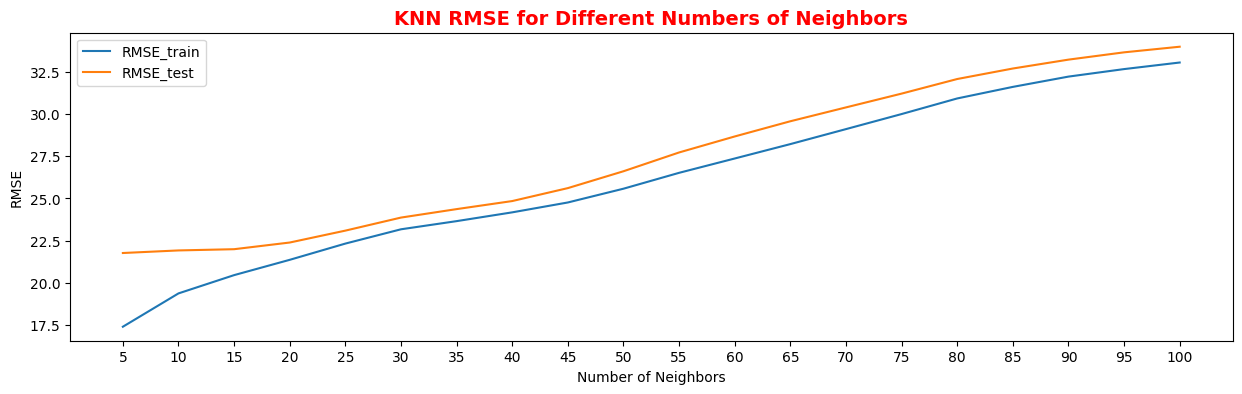

Optimal n_neighbors: 40
RMSE Train: 24.178, RMSE Test: 24.848
Final RMSE on Test Set: 24.848


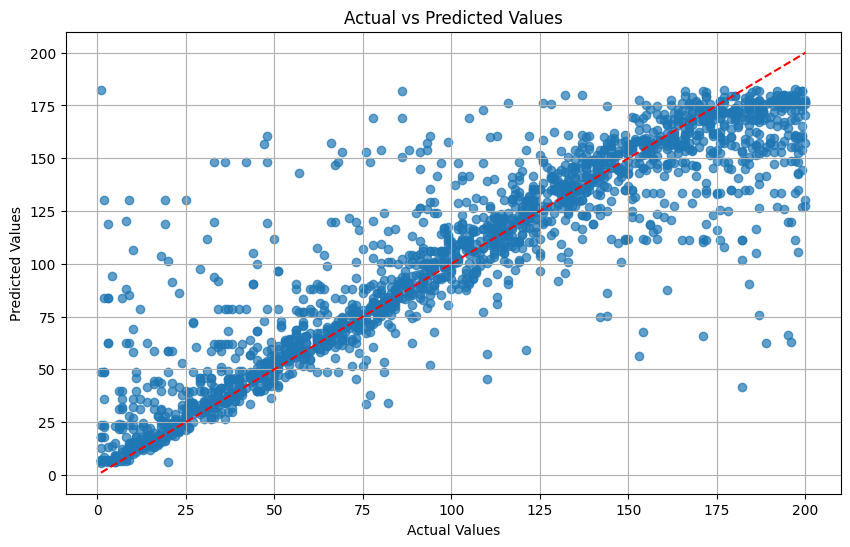

Model saved as 'best_knn_model.pkl'
R² Score: 0.815
Cross-Validation RMSE: 31.859 ± 3.753


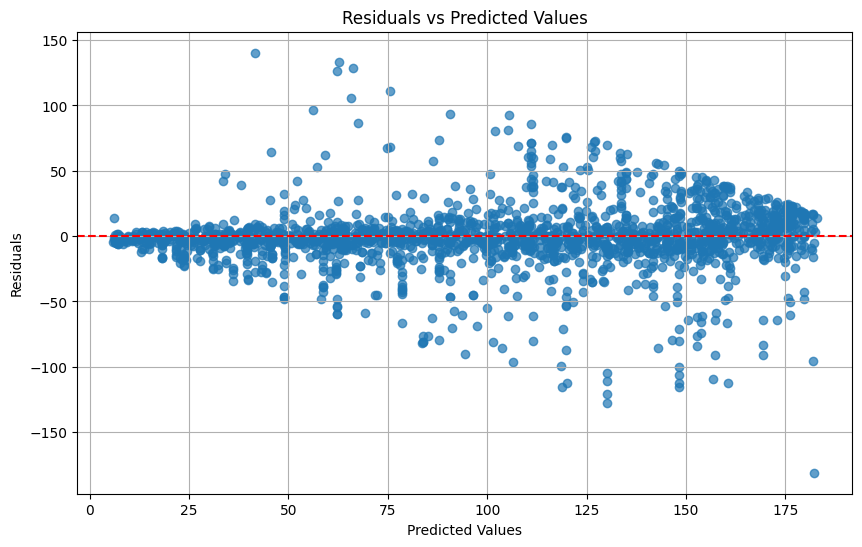

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
import joblib

# 데이터 불러오기
data = pd.read_csv(r"C:\Users\user\Desktop\MusicTrendAnalysis\data\merged_data.csv", index_col=0)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data.drop(["Rank"], axis=1), data["Rank"], test_size=0.2, random_state=10)

# 5부터 100까지 이웃 수에 대한 RMSE 계산
RMSE_train, RMSE_test = [], []

for i in range(5, 101, 5):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    
    # 훈련 데이터에 대한 예측 및 RMSE 계산
    y_train_pred = knn.predict(X_train)
    knn_train_rmse = np.sqrt(mse(y_train, y_train_pred))
    RMSE_train.append(knn_train_rmse.round(3))
    
    # 테스트 데이터에 대한 예측 및 RMSE 계산
    y_test_pred = knn.predict(X_test)
    knn_test_rmse = np.sqrt(mse(y_test, y_test_pred))
    RMSE_test.append(knn_test_rmse.round(3))

# RMSE 시각화
fig, ax = plt.subplots(figsize=(15, 4))
x = np.arange(5, 101, 5)
sns.lineplot(x=x, y=RMSE_train, label='RMSE_train', ax=ax)
sns.lineplot(x=x, y=RMSE_test, label='RMSE_test', ax=ax)
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('RMSE')
ax.set_xticks(np.arange(5, 101, 5))
ax.set_title('KNN RMSE for Different Numbers of Neighbors', c='r', fontsize=14, weight='bold')
plt.legend()
plt.show()

# RMSE 차이를 계산하여 최적의 n_neighbors 찾기
gap = [RMSE_test[num] - RMSE_train[num] for num in range(len(RMSE_train))]
optimal_index = gap.index(min(gap))
optimal_n_neighbors = 5 + optimal_index * 5

print(f'Optimal n_neighbors: {optimal_n_neighbors}')
print(f'RMSE Train: {RMSE_train[optimal_index]}, RMSE Test: {RMSE_test[optimal_index]}')

# 최적의 모델로 다시 훈련
best_knn = KNeighborsRegressor(n_neighbors=optimal_n_neighbors)
best_knn.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_final_pred = best_knn.predict(X_test)

# 최종 RMSE 계산
final_rmse = np.sqrt(mse(y_test, y_final_pred))
print(f'Final RMSE on Test Set: {final_rmse:.3f}')

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_final_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid()
plt.show()

# 모델을 파일로 저장
joblib.dump(best_knn, 'best_knn_model.pkl')
print("Model saved as 'best_knn_model.pkl'")

# R² 계산
r2 = r2_score(y_test, y_final_pred)
print(f'R² Score: {r2:.3f}')

# KNN 모델에 대한 교차 검증 수행
cross_val_scores = cross_val_score(best_knn, data.drop(["Rank"], axis=1), data["Rank"], cv=5, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_scores)
print(f'Cross-Validation RMSE: {cross_val_rmse.mean():.3f} ± {cross_val_rmse.std():.3f}')

# 잔차 분석
residuals = y_test - y_final_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_final_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid()
plt.show()


Optimal n_neighbors: 9
Final RMSE on Test Set: 19.866
R² Score: 0.882
Model saved as 'best_knn_model_2.pkl'


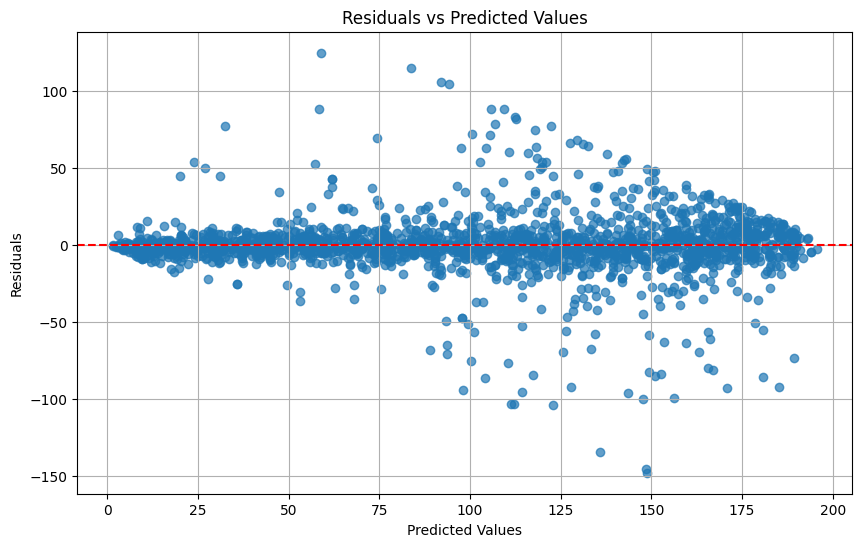

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import joblib

# 데이터 불러오기
data = pd.read_csv(r"C:\Users\user\Desktop\MusicTrendAnalysis\data\merged_data.csv", index_col=0)

# 데이터 전처리: 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop(["Rank"], axis=1))

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, data["Rank"], test_size=0.2, random_state=10)

# 특성 선택 (예: 상위 10개 특성 선택)
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# KNN 모델을 위한 하이퍼파라미터 튜닝
param_grid = {'n_neighbors': np.arange(1, 101, 1)}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_selected, y_train)

# 최적의 n_neighbors
optimal_n_neighbors = grid_search.best_params_['n_neighbors']
print(f'Optimal n_neighbors: {optimal_n_neighbors}')

# 최적의 모델로 훈련
best_knn = KNeighborsRegressor(n_neighbors=optimal_n_neighbors)
best_knn.fit(X_train_selected, y_train)

# 테스트 데이터에 대한 예측
y_final_pred = best_knn.predict(X_test_selected)

# 최종 RMSE 및 R² 계산
final_rmse = np.sqrt(mse(y_test, y_final_pred))
r2 = r2_score(y_test, y_final_pred)

print(f'Final RMSE on Test Set: {final_rmse:.3f}')
print(f'R² Score: {r2:.3f}')

# 모델을 파일로 저장
joblib.dump(best_knn, 'best_knn_model_2.pkl')
print("Model saved as 'best_knn_model_2.pkl'")

# 잔차 분석
residuals = y_test - y_final_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_final_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid()
plt.show()
